**EXP2 Predicitng Missing Cell-Types from Bulks using CIBERSORTx Residual**

*This file includes EXP2 results (details outlined in link below).*

Experimental Details: https://docs.google.com/spreadsheets/d/1fMV_URm95iPh-6rew-Be27I1-i8PNgGNWi2D_UO2V9w/edit#gid=0

Summary: Analyzing results form BayesPrism deconvolution done in EXP2_bayesprism_pbmc.R.

*This file is intended to be run through Papermill in EXP2.py. See EXP2.py for details*

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#these parameters are set in papermill 
res_name = "MCT_pbmc_EXP2"
pseudos_name = "MCT_pbmc_EXP1"
path = "/../data/"
aug_data_path = "/../data/EXP2/"
data_path = "/../data/EXP1/"
cibersort_path = "/../data/EXP2/cibersort_results/"
bulk_type = "randomprop_nonoise"
noise_type = "nonoise"
num_missing_cells = [0,1,2,3,4]
nmf_cut = "minimum_value"
num_samples = 10000

In [3]:
# Parameters
res_name = "MCT_pbmc_EXP2"
pseudos_name = "MCT_pbmc_EXP1"
path = "/data/"
aug_data_path = "/data/EXP2/"
data_path = "/data/EXP1/"
cibersort_path = "/data/EXP2/cibersort_results/"
bulk_type = "randomprop_noise"
noise_type = "noise"
random_seed = 88
num_missing_cells = [0, 1, 2, 3, 4]
num_samples = 10000
nmf_cut = "minimum_value"
kernel_name = "env_ml"


In [4]:
actual_path = os.getcwd()
path = f"{actual_path}{path}"
aug_data_path = f"{actual_path}{aug_data_path}"
data_path = f"{actual_path}{data_path}"
cibersort_path = f"{actual_path}{cibersort_path}"

Opening mixture file of pseudobulks and anndata for reference:

In [5]:
pseudo_path = os.path.join(aug_data_path, f"{res_name}_{bulk_type}_mixture.txt")
pseudo_path = Path(pseudo_path)
# Open the file of mixture used
pseudo_df = pd.read_csv(pseudo_path, sep="\t")
#extracting gene_ids and setting as columns
pseudo_df.rename(columns = {'Unnamed: 0':'gene_ids'}, inplace = True)
gene_ids = pseudo_df["gene_ids"]
pseudo_df = pseudo_df.T
pseudo_df.columns = gene_ids
pseudo_df = pseudo_df.drop(labels = "gene_ids")
pseudo_df_copy = pseudo_df.copy()
pseudo_df

gene_ids,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
0,260.431052,0.0,162.099397,157.453617,1326.489521,482118.516118,136.990628,139.706042,152.087456,1518844.625951,...,1023321.192401,752024914.236923,22283421.98616,491758.898041,747872029.272438,4949.497019,627654.64861,1854.288611,31254.504699,20191.621233
1,3.109866,0.0,2.476534,37.799057,2299.127185,603366.619629,296.87113,131.559777,168.258346,3387044.378216,...,760062.488129,895047274.00514,35700990.183509,406742.856609,1071459032.481423,6540.62397,525701.031726,2653.41013,52449.977572,28673.357085
2,804.473747,83.428134,11.934176,107.602483,1472.566205,284328.19218,243.452283,63.993455,50.839794,424814.20704,...,759363.124644,653317856.919151,22334864.888166,170854.651438,637686974.722709,1665.363914,423100.326121,189.977575,48814.854631,6253.957382
3,84.279083,3.816787,38.198635,110.663207,2224.164759,412519.941823,173.722653,42.942543,24.018486,850130.362786,...,581821.761757,994431605.543537,24963392.732649,432730.445443,497118640.278541,1329.852404,382639.908694,701.113133,62045.939096,19915.065471
4,721.121388,115.475799,9.018028,180.944558,1316.42774,274587.461056,96.251304,64.293871,36.388834,355421.389662,...,606820.452952,452940298.394316,23748034.054709,245871.593822,576758972.433737,2470.570012,334014.07071,400.533168,32925.311214,8725.198077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1045.847651,61.6201,0.832962,28.3586,2453.47117,303421.145483,177.96161,532.515653,152.259362,350326.497224,...,658173.150959,542552264.374422,20122723.513574,210736.725096,335884699.289243,1717.815454,349545.006082,221.215597,31930.504671,6485.211843
996,1525.233589,48.43561,0.0,255.966754,1364.590575,227116.625726,95.722909,177.222611,157.445163,823516.256057,...,916484.901563,624508569.32637,17503045.438547,182304.914589,381834283.240344,1668.771196,417159.573256,1045.784721,26977.373999,7216.906167
997,2576.302201,75.528248,10.338891,535.301479,3035.160306,199614.109555,33.823317,447.186406,137.871574,155348.332163,...,342724.338029,489322813.412636,11112910.719804,166667.390011,371524489.566961,2692.968033,280292.976248,111.715331,29357.01472,2086.899965
998,46.493183,35.870142,19.82558,39.39485,857.047083,303888.098961,62.700847,70.259436,69.34966,315310.563678,...,599428.882048,553112522.404963,14819615.941687,266252.835528,339262076.458413,517.195115,467904.136308,135.237654,39407.859187,10690.733623


In [6]:
#and importing anndata object
adata_path = os.path.join(aug_data_path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata_copy = sn_adata.copy()
sn_adata

AnnData object with n_obs × n_vars = 2589 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'scpred_CellType', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_types_colors', 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [7]:
#QC
print(Counter(sn_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sn_adata.obs.cell_types.unique())
cell_order = sn_adata.obs.cell_types.unique()

Counter({'CD4 T': 1131, 'CD14 Monocytes': 436, 'B': 342, 'CD8 T': 317, 'NK': 200, 'FCGR3A Monocytes': 163})


Making Cell Type Reference:

In [8]:
# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw.index = gene_ids.index

In [9]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df.index = gene_ids.index
ref_df_copy = ref_df.copy()

## **Reading In and QCing the CIBERSORTx Results:**

CIBERSORTx Results:

In [10]:
#import all CIBERSORTx results and real proportions
cibersort_prop = dict()
real_prop_reb = dict()
real_prop = dict()
ref_cibersort = dict()
for num in num_missing_cells:
    #import cibersort proportions
    cibersort_results_path = os.path.join(cibersort_path, f"CIBERSORTx_{res_name}_{num}missing_{bulk_type}_Results.txt")
    cibersort_results_path = Path(cibersort_results_path)
    # Open the CSV file in read mode
    cibersort_prop[num] = pd.read_csv(cibersort_results_path, sep="\t")
    cibersort_prop[num] = cibersort_prop[num].drop(labels = ["Mixture", "P-value", "Correlation", "RMSE"], axis = 1)
    cibersort_prop[num]

    #real proportions
    realprop_results_path = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulk_type}_prop.csv")
    realprop_results_path = Path(realprop_results_path)
    # Open the CSV file in read mode
    real_prop[num] = pd.read_csv(realprop_results_path, sep=",")

    #real rebalanced proportions
    realrebprop_results_path = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulk_type}_prop.csv")
    realrebprop_results_path = Path(realrebprop_results_path)
    # Open the CSV file in read mode
    real_prop_reb[num] = pd.read_csv(realrebprop_results_path, sep=",")

    #and the reference used in cibersort
    ref_results_path = os.path.join(cibersort_path, f"CIBERSORTx_{res_name}_{num}missing_signal_inferred_phenoclasses.CIBERSORTx_{res_name}_{num}missing_signal_inferred_refsample.bm.K999.txt")
    ref_results_path = Path(ref_results_path)
    # Open the CSV file in read mode
    ref_cibersort[num] = pd.read_csv(ref_results_path, sep="\t")
    ref_cibersort[num] = ref_cibersort[num].rename(columns = {'NAME':'gene_ids'})
    ref_cibersort[num].index = ref_cibersort[num]["gene_ids"]
    gene_ids[num] = ref_cibersort[num].index
    ref_cibersort[num] = ref_cibersort[num].drop(labels= "gene_ids", axis = 1)
    #match columns and index
    cibersort_prop[num].columns =  real_prop[num].columns
    cibersort_prop[num].index =  real_prop[num].index

/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_74810/1754332774.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_ids[num] = ref_cibersort[num].index


In [11]:
#matching genes in reference, pseudobulks in gene_ids[num]
sn_adata = dict()
ref_df = dict()
gene_ids = dict()
#copying pseudobulks
pseudo_df_copy = pseudo_df.copy()
pseudo_df = dict()
for num in num_missing_cells:
    #cutting to gene_ids in reference
    pseudo_df[num] = pseudo_df_copy.copy()
    gene_ids[num] = pseudo_df[num].columns
    sn_adata[num] = sn_adata_copy[:, gene_ids[num]]
    ref_df[num] = ref_df_copy.loc[gene_ids[num], :]
    print(gene_ids[num].shape)
    #and  deleting missing cells form reference
    ref_df[num] = ref_df[num].filter(ref_cibersort[num].columns)

(13714,)
(13714,)
(13714,)
(13714,)


(13714,)


In [12]:
#using rebalanced proportions (summing to one) after deleting cell types
real_prop = real_prop_reb

QC imported files:

In [13]:
cibersort_prop[0]

,FCGR3A Monocytes,B,CD4 T,NK,CD8 T,CD14 Monocytes
0,0.134524,0.298714,0.000000,0.269463,0.138202,0.159097
1,0.140110,0.256809,0.062126,0.391961,0.048570,0.100423
2,0.162442,0.131748,0.024753,0.054860,0.039192,0.587005
3,0.169998,0.215032,0.062142,0.312133,0.149842,0.090853
4,0.101176,0.091038,0.024075,0.079857,0.087471,0.616383
...,...,...,...,...,...,...
995,0.061420,0.076846,0.010264,0.038823,0.162516,0.650131
996,0.045491,0.056567,0.019090,0.033339,0.027933,0.817579
997,0.036532,0.056019,0.050065,0.020547,0.027680,0.809157
998,0.244892,0.143743,0.000000,0.193097,0.288245,0.130023


In [14]:
real_prop[0]

,FCGR3A Monocytes,B,CD4 T,NK,CD8 T,CD14 Monocytes
0,0.0866,0.3104,0.0182,0.2746,0.2412,0.0690
1,0.2556,0.1886,0.0656,0.4004,0.0562,0.0336
2,0.2352,0.1374,0.0218,0.0950,0.0914,0.4192
3,0.1348,0.1568,0.1992,0.2302,0.2186,0.0604
4,0.0846,0.1482,0.1558,0.1214,0.1682,0.3218
...,...,...,...,...,...,...
995,0.1724,0.0352,0.0434,0.1364,0.2648,0.3478
996,0.1058,0.1050,0.0188,0.2186,0.0856,0.4662
997,0.0746,0.0746,0.0742,0.0614,0.0670,0.6482
998,0.3142,0.1138,0.0538,0.1392,0.3206,0.0584


In [15]:
real_prop[0]

,FCGR3A Monocytes,B,CD4 T,NK,CD8 T,CD14 Monocytes
0,0.0866,0.3104,0.0182,0.2746,0.2412,0.0690
1,0.2556,0.1886,0.0656,0.4004,0.0562,0.0336
2,0.2352,0.1374,0.0218,0.0950,0.0914,0.4192
3,0.1348,0.1568,0.1992,0.2302,0.2186,0.0604
4,0.0846,0.1482,0.1558,0.1214,0.1682,0.3218
...,...,...,...,...,...,...
995,0.1724,0.0352,0.0434,0.1364,0.2648,0.3478
996,0.1058,0.1050,0.0188,0.2186,0.0856,0.4662
997,0.0746,0.0746,0.0742,0.0614,0.0670,0.6482
998,0.3142,0.1138,0.0538,0.1392,0.3206,0.0584


In [16]:
ref_cibersort[0]

,FCGR3A Monocytes,B,CD4 T,NK,CD8 T,CD14 Monocytes
gene_ids,,,,,,
AAK1,154.411587,1.00000,130.712475,1.000000,92.080539,1.000000
AAMP,1.000000,115.67895,1.000000,59.999835,1.000000,1.000000
AATF,1.000000,1.00000,1.000000,1.000000,110.493742,1.000000
ABHD14A,89.507135,1.00000,1.000000,1.000000,152.123621,1.000000
ABHD14B,121.033946,1.00000,118.404156,1.000000,128.271201,1.000000
...,...,...,...,...,...,...
ZNF593,1.000000,1.00000,1.000000,69.323658,1.000000,1.000000
ZNF703,1.000000,1.00000,1.000000,98.951470,1.000000,1.000000
ZRANB2,1.000000,100.87210,1.000000,1.000000,1.000000,1.000000


In [17]:
pseudo_df[0]

gene_ids,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
0,260.431052,0.0,162.099397,157.453617,1326.489521,482118.516118,136.990628,139.706042,152.087456,1518844.625951,...,1023321.192401,752024914.236923,22283421.98616,491758.898041,747872029.272438,4949.497019,627654.64861,1854.288611,31254.504699,20191.621233
1,3.109866,0.0,2.476534,37.799057,2299.127185,603366.619629,296.87113,131.559777,168.258346,3387044.378216,...,760062.488129,895047274.00514,35700990.183509,406742.856609,1071459032.481423,6540.62397,525701.031726,2653.41013,52449.977572,28673.357085
2,804.473747,83.428134,11.934176,107.602483,1472.566205,284328.19218,243.452283,63.993455,50.839794,424814.20704,...,759363.124644,653317856.919151,22334864.888166,170854.651438,637686974.722709,1665.363914,423100.326121,189.977575,48814.854631,6253.957382
3,84.279083,3.816787,38.198635,110.663207,2224.164759,412519.941823,173.722653,42.942543,24.018486,850130.362786,...,581821.761757,994431605.543537,24963392.732649,432730.445443,497118640.278541,1329.852404,382639.908694,701.113133,62045.939096,19915.065471
4,721.121388,115.475799,9.018028,180.944558,1316.42774,274587.461056,96.251304,64.293871,36.388834,355421.389662,...,606820.452952,452940298.394316,23748034.054709,245871.593822,576758972.433737,2470.570012,334014.07071,400.533168,32925.311214,8725.198077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1045.847651,61.6201,0.832962,28.3586,2453.47117,303421.145483,177.96161,532.515653,152.259362,350326.497224,...,658173.150959,542552264.374422,20122723.513574,210736.725096,335884699.289243,1717.815454,349545.006082,221.215597,31930.504671,6485.211843
996,1525.233589,48.43561,0.0,255.966754,1364.590575,227116.625726,95.722909,177.222611,157.445163,823516.256057,...,916484.901563,624508569.32637,17503045.438547,182304.914589,381834283.240344,1668.771196,417159.573256,1045.784721,26977.373999,7216.906167
997,2576.302201,75.528248,10.338891,535.301479,3035.160306,199614.109555,33.823317,447.186406,137.871574,155348.332163,...,342724.338029,489322813.412636,11112910.719804,166667.390011,371524489.566961,2692.968033,280292.976248,111.715331,29357.01472,2086.899965
998,46.493183,35.870142,19.82558,39.39485,857.047083,303888.098961,62.700847,70.259436,69.34966,315310.563678,...,599428.882048,553112522.404963,14819615.941687,266252.835528,339262076.458413,517.195115,467904.136308,135.237654,39407.859187,10690.733623


In [18]:
ref_df[0]

,FCGR3A Monocytes,B,CD4 T,NK,CD8 T,CD14 Monocytes
gene_ids,,,,,,
AL627309.1,0.000000,0.000000,0.003198,0.000000,0.008793,0.035440
AP006222.2,0.000000,0.000000,0.000799,0.000000,0.007461,0.005596
RP11-206L10.2,0.000000,0.015455,0.002665,0.000000,0.000000,0.000000
RP11-206L10.9,0.000000,0.000000,0.000000,0.013590,0.000000,0.011191
LINC00115,0.012524,0.020518,0.015188,0.027446,0.014656,0.024781
...,...,...,...,...,...,...
AC145212.1,0.000000,0.015988,0.010392,0.059688,0.006129,0.031709
AL592183.1,0.316559,0.466312,0.372783,0.308832,0.348802,0.264865
AL354822.1,0.000000,0.014656,0.006928,0.046898,0.000000,0.005596


In [19]:
###QC dimensions
for num in gene_ids:
    print(gene_ids[num].shape)
    print(ref_df[num].shape)
    print(pseudo_df[num].shape)
    print(ref_cibersort[num].shape)

(13714,)
(13714, 6)
(1000, 13714)
(1314, 6)
(13714,)
(13714, 5)
(1000, 13714)
(1254, 5)
(13714,)
(13714, 4)
(1000, 13714)
(1252, 4)
(13714,)
(13714, 3)
(1000, 13714)
(686, 3)
(13714,)
(13714, 2)
(1000, 13714)
(610, 2)


Visualize CIBERSORTx proportions:

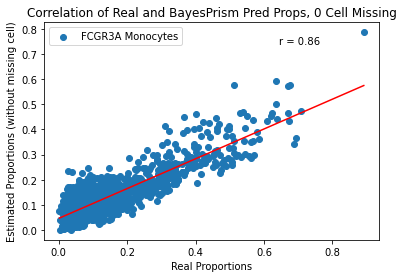

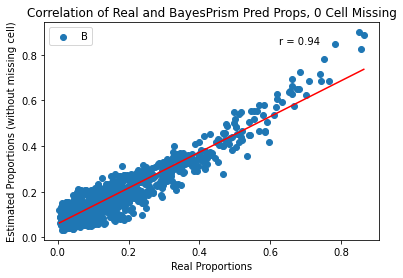

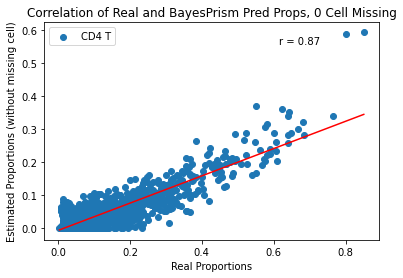

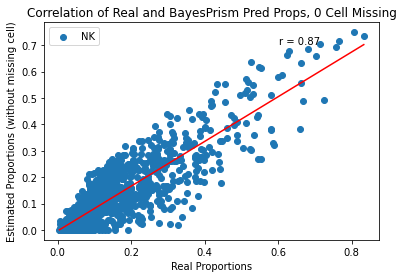

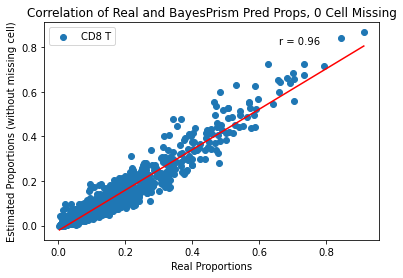

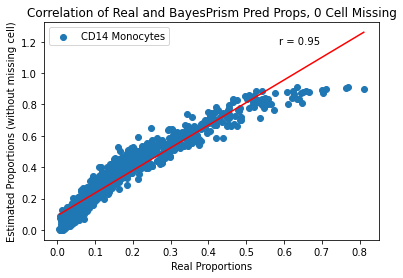

In [20]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in real_prop[num].columns:
    x = real_prop[num][col_cell].values.astype(float)
    y = cibersort_prop[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and BayesPrism Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 6)
Estimated Proportions shape: (1000, 6)


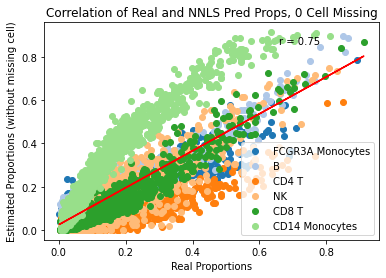

Real Proportions shape: (1000, 5)
Estimated Proportions shape: (1000, 5)


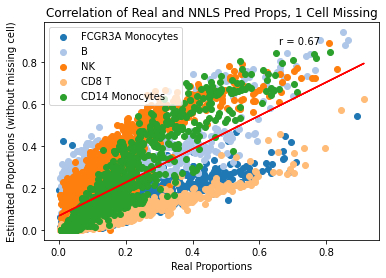

Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


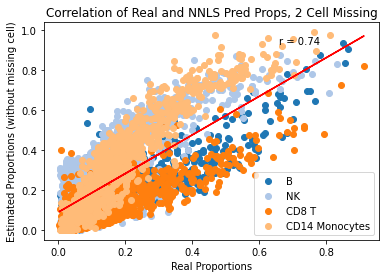

Real Proportions shape: (1000, 3)
Estimated Proportions shape: (1000, 3)


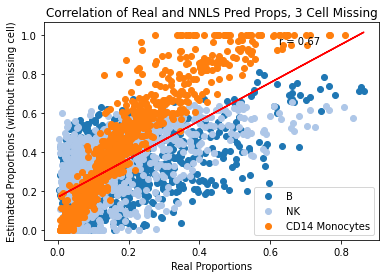

Real Proportions shape: (1000, 2)
Estimated Proportions shape: (1000, 2)


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


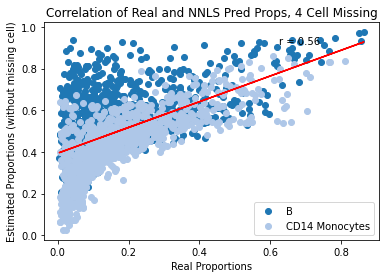

In [21]:
#Comparing performance for all cell types with num_cells_missing.
# define colormap for coloring cell types
cmap = get_cmap('tab20') 
for num in num_missing_cells:
    real_proportions = real_prop_reb[num].values.astype(float) #real proportions of present cells
    estimated_proportions = cibersort_prop[num].values.astype(float) #estimated proportions of present cells.
    cell_types = real_prop_reb[num].columns.tolist() 
    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    #scatter plot with colored points for each cell type
    fig, ax = plt.subplots()
    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]
        color = cmap(i)  #unique color for each cell type
        ax.scatter(x, y, label=cell_type, color=color)
    #fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend(loc='best')  #show the cell type labels in the legend
    plt.show()

Compare Error: Real Proportions - Estimated Proportions 

In [22]:
#the difference between calculated and real proportions.
custom_res_tot = dict()
for num in num_missing_cells:
    custom_res_tot[num] = real_prop[num].values - cibersort_prop[num]

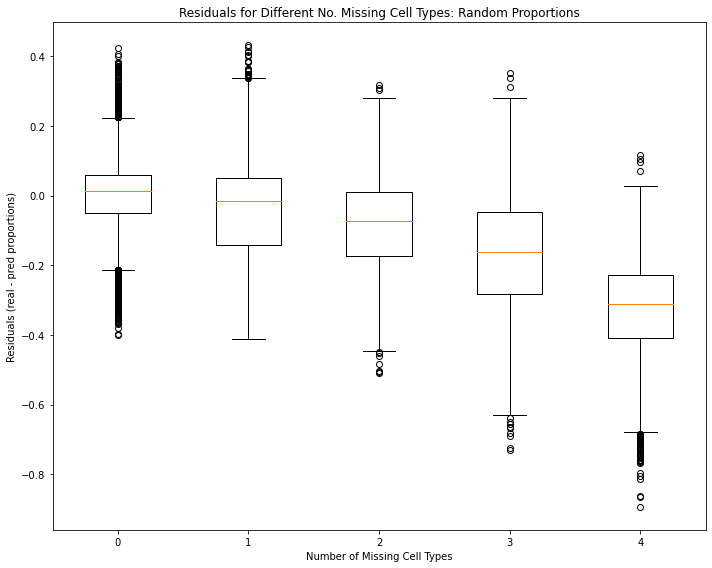

In [23]:
#Distribution of residuals as the difference between calculated and real proportions.
#the difference between calculated and real proportions.
custom_res_tot = dict()
for num in num_missing_cells:
    custom_res_tot[num] = real_prop[num].values - cibersort_prop[num]
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

## **Extracting Missing Cell Information:**

In [24]:
cells_to_miss = dict()
missing_cell_tot  = dict()
for num in num_missing_cells:
    #cells that are missing
    cells_to_miss[num] = np.setdiff1d(ref_df[0].columns, ref_cibersort[num].columns)
    #extracting real proportions from missing cells
    missing_cell_tot[num] = real_prop[0][cells_to_miss[num]]
    print(f"{num} missing: {missing_cell_tot[num].shape}")

0 missing: (1000, 0)
1 missing: (1000, 1)
2 missing: (1000, 2)
3 missing: (1000, 3)
4 missing: (1000, 4)


In [25]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = real_prop[0][missing_cell_tot[num].columns]  
    print(f"{num} missing: prop is {missing_cell_prop[num].shape}")

1 missing: prop is (1000, 1)
2 missing: prop is (1000, 2)
3 missing: prop is (1000, 3)
4 missing: prop is (1000, 4)


## **Calculate Residuals:**

1. Residual uses:

pseudobulks (scaled) -  (reference used (ref_bp, scaled) * calculated proportions (calc_prop_tot))

In [26]:
#Residual: pseudobulks as used, minus reference of ciberef_cibersort * calculated proportions
residuals = dict()
for num in num_missing_cells:
    res = (pseudo_df[num].values) - (cibersort_prop[num] @ ref_df[num].T)
    residuals[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals[3]    

gene_ids,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
0,260.426651,-0.000695,162.094467,157.44466,1326.464617,482118.152257,136.979872,139.704288,152.076883,1518844.034628,...,1023320.728898,752024913.236923,22283420.98616,491758.6573,747872028.272438,4949.454745,627654.295002,1854.257128,31254.414973,20191.528211
1,3.107054,-0.000444,2.471815,37.789807,2299.102067,603366.242663,296.85995,131.558657,168.247372,3387043.737885,...,760062.018528,895047273.00514,35700989.183509,406742.610481,1071459031.481423,6540.579848,525700.678291,2653.376357,52449.886365,28673.257564
2,804.444679,83.423544,11.933022,107.591875,1472.541462,284327.970902,243.4463,63.981871,50.828031,424813.934667,...,759362.704829,653317855.919151,22334863.888166,170854.426352,637686973.722709,1665.330437,423100.041595,189.966961,48814.77672,6253.93882
3,84.275421,3.816209,38.192846,110.654956,2224.140184,412519.580143,173.711947,42.941084,24.008733,850129.808701,...,581821.302343,994431604.543537,24963391.732649,432730.21143,497118639.278541,1329.811975,382639.54542,701.082579,62045.850198,19914.97302
4,721.100326,115.472473,9.014946,180.935104,1316.403259,274587.199586,96.243954,64.285478,36.378197,355421.057898,...,606820.024048,452940297.394316,23748033.054709,245871.370442,576758971.433737,2470.535668,334013.7566,400.517247,32925.230582,8725.157989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1045.822431,61.616118,0.831056,28.348393,2453.446475,303420.903374,177.954924,532.505603,152.247957,350326.185355,...,658172.725512,542552263.374422,20122722.513574,210736.499147,335884698.289243,1717.781067,349544.70911,221.202068,31930.425175,6485.182278
996,1525.203154,48.430805,-0.000771,255.955901,1364.565763,227116.410846,95.717146,177.210482,157.433152,823515.990457,...,916484.482911,624508568.32637,17503044.438547,182304.688693,381834282.240344,1668.737715,417159.294328,1045.7749,26977.296466,7216.891078
997,2576.266762,75.522652,10.338891,535.290287,3035.135525,199613.923563,33.81852,447.172284,137.859317,155348.130982,...,342723.928208,489322812.412636,11112909.719804,166667.167247,371524488.566961,2692.936324,280292.711383,111.709735,29356.939577,2086.899965
998,46.489666,35.869587,19.819007,39.387277,857.022848,303887.743035,62.69031,70.258035,69.340715,315310.055529,...,599428.427892,553112521.404963,14819614.941687,266252.608777,339262075.458413,517.156788,467903.764867,135.208567,39407.771427,10690.643597


In [27]:
#scaling
ref_df_scaled = dict()
pseudo_scaled = dict()
for num in num_missing_cells:
    #clippign before scaling to 95th pecentile
    ref_raw_val = ref_df[num].values ##reference created
    clip_upper = np.quantile(ref_raw_val, 0.90)
    ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(ref_raw_val)
    ref_scale = scaler.transform(ref_raw_val)
    ref_df_scaled[num] = pd.DataFrame(ref_scale, index = ref_df[num].index, columns = real_prop[num].columns)
    print(ref_df_scaled[num].shape)
    #clippign before scaling to 95th pecentile
    pseudo_raw_val = pseudo_df[num][ref_df[num].index].values ##pseudobulks
    clip_upper = np.quantile(pseudo_raw_val, 0.90)
    pseudo_raw_val = np.clip(pseudo_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    pseudo_scaled[num] = pd.DataFrame(pseudo_scale, columns = gene_ids[num])
    print(pseudo_df[num].shape)

(13714, 6)


(1000, 13714)
(13714, 5)


(1000, 13714)
(13714, 4)


(1000, 13714)
(13714, 3)


(1000, 13714)
(13714, 2)


(1000, 13714)


In [28]:
print(ref_cibersort[1].max().max())
print(ref_df_scaled[1].max().max())

21945.7361154186
1.0


In [29]:
print(pseudo_df[1].max().max())
print(pseudo_scaled[1].max().max())

480862988996.6135
1.0000000000000009


In [30]:
#Residual with the scaled pseudobulk and scaled bayes prism reference
residuals_scaled = dict()
for num in num_missing_cells:
    res = (pseudo_scaled[num].values)  - (cibersort_prop[num] @ ref_df_scaled[num].T)
    residuals_scaled[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals_scaled[0]    

gene_ids,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
0,0.047754,-0.003860,0.101672,0.154676,0.164223,-0.142161,0.103972,0.089075,0.104870,0.640245,...,0.129223,-1.0,-1.0,-0.034320,-1.0,0.323184,-0.129742,0.305891,-0.051080,0.136814
1,-0.007672,-0.001957,-0.006611,0.026798,0.346045,-0.022380,0.243786,0.085163,0.114817,0.543639,...,-0.184819,-1.0,-1.0,-0.162019,-1.0,0.434557,-0.255348,0.442707,0.095766,0.229112
2,0.147401,0.148639,0.003945,0.098480,0.190625,-0.234998,0.203861,0.022412,0.023060,0.139815,...,-0.128083,-1.0,-1.0,-0.401642,-1.0,0.077621,-0.301246,0.019033,0.088354,0.025951
3,0.010395,0.003764,0.019135,0.105831,0.334782,-0.254953,0.136301,0.018859,0.006140,0.524158,...,-0.431047,-1.0,-1.0,-0.148175,-1.0,0.048008,-0.437933,0.091633,0.158858,0.118035
4,0.124770,0.207459,0.003217,0.174279,0.160174,-0.256755,0.073075,0.023409,0.010348,0.033071,...,-0.347467,-1.0,-1.0,-0.298420,-1.0,0.134800,-0.404658,0.056375,-0.022813,0.057948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.197842,0.105361,-0.001871,0.014150,0.374866,-0.208079,0.144808,0.360763,0.100443,0.056130,...,-0.251737,-1.0,-1.0,-0.316327,-1.0,0.080065,-0.380590,0.027412,-0.024740,0.034910
996,0.301489,0.080849,-0.001859,0.249933,0.166527,-0.263414,0.073735,0.102235,0.100508,0.499415,...,0.121428,-1.0,-1.0,-0.335791,-1.0,0.068444,-0.261385,0.178541,-0.050352,0.065775
997,0.550196,0.131514,0.005069,0.544276,0.481834,-0.297844,0.019209,0.297135,0.085999,-0.192411,...,-0.728472,-1.0,-1.0,-0.351803,-1.0,0.147886,-0.444065,0.007218,-0.034654,-0.007865
998,-0.003366,0.061232,0.009106,0.033240,0.080594,-0.356164,0.040743,0.033362,0.044111,0.061783,...,-0.376436,-1.0,-1.0,-0.365941,-1.0,-0.000217,-0.305141,0.001046,-0.014979,0.018632


## NMF of Residual:

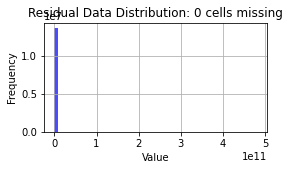

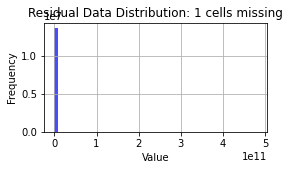

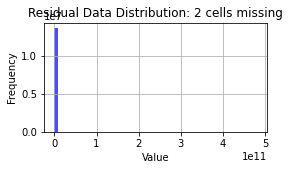

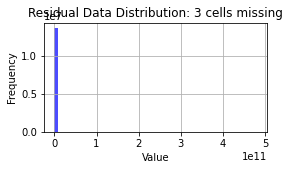

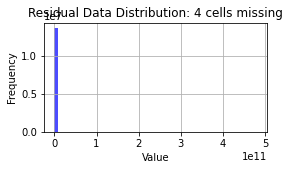

In [31]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

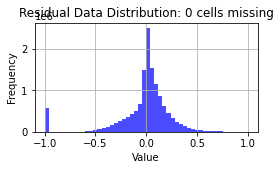

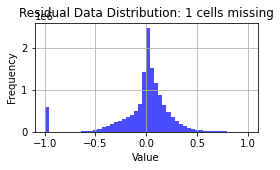

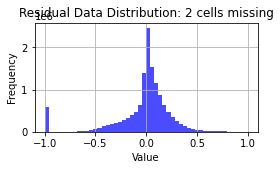

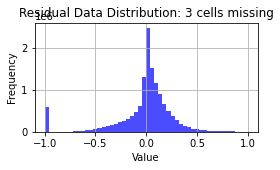

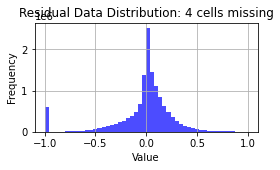

In [32]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.08482126347463156


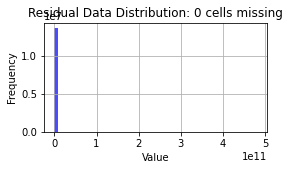

0.16296590434892747


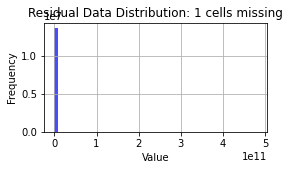

0.2711568873635917


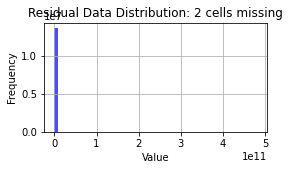

0.4611358014698104


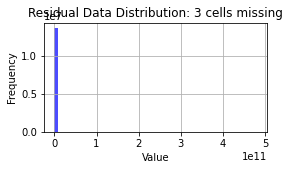

0.38537848231117455


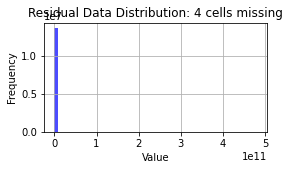

In [33]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals.copy()
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [34]:
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf)
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shifting distributions according to above plots, and calculating NMF:

0.9999999403953569


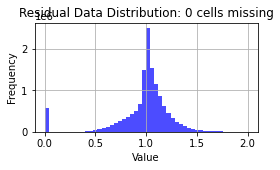

1.0000000000000018


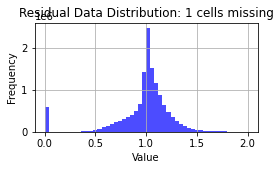

1.0000000000000013


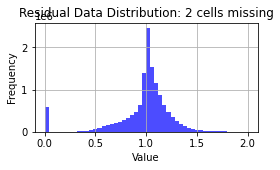

1.000000000000001


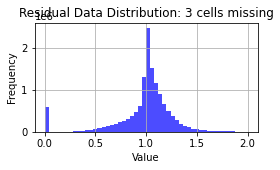

1.0000000000000009


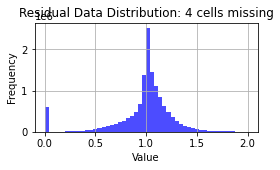

In [35]:
#shift_scaleding distribution of residuals to do NMF
residuals_shift_scaled = residuals_scaled
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift_scaled distributions minimally:
        min_val = abs(np.min(np.min(residuals_scaled[num])))
        print(min_val)
        residuals_shift_scaled[num] = residuals_scaled[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift_scaled[num][residuals_shift_scaled[num].values <= 0] = 0
    data = residuals_shift_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [36]:
#nmf on residual 1
res_nmf_scaled = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf)
    res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf_scaled[num] = res_nmf_df

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Residual

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


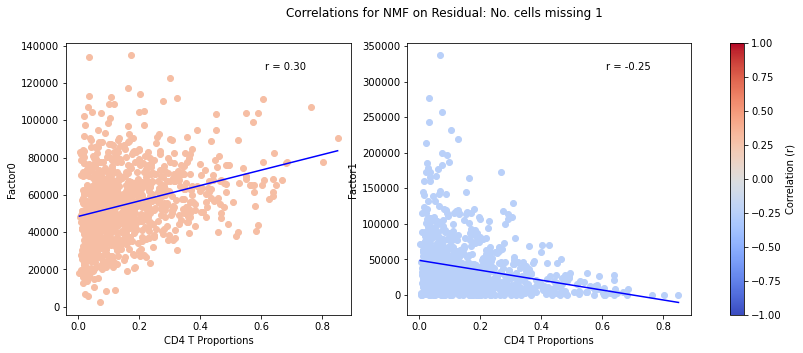

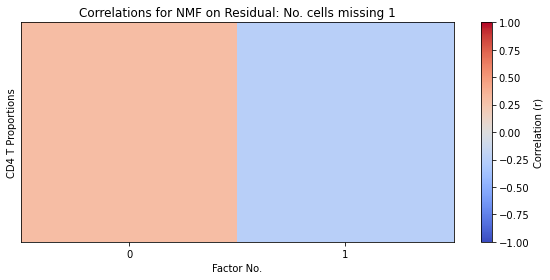

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


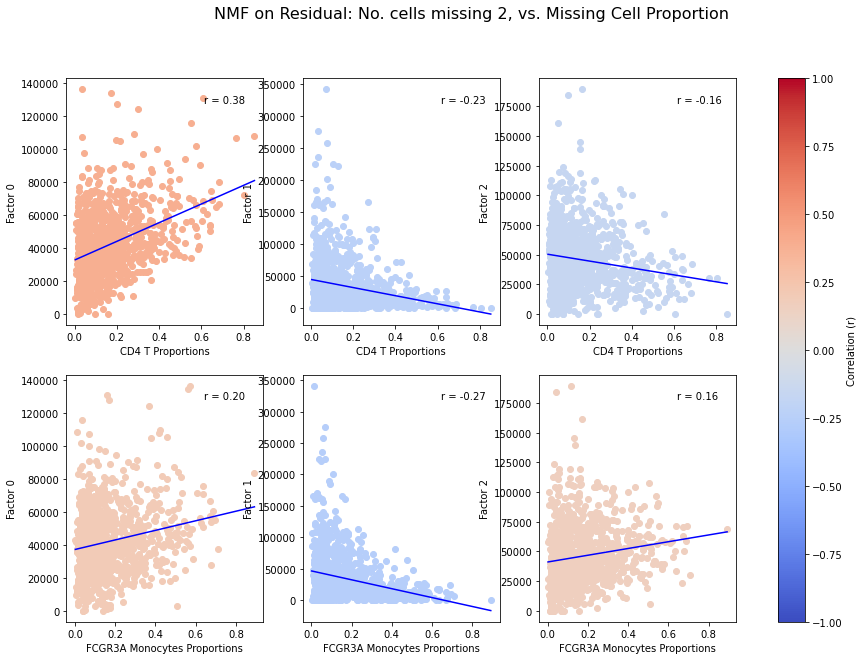

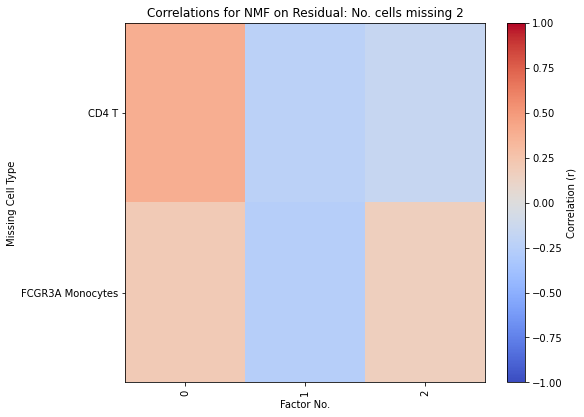

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


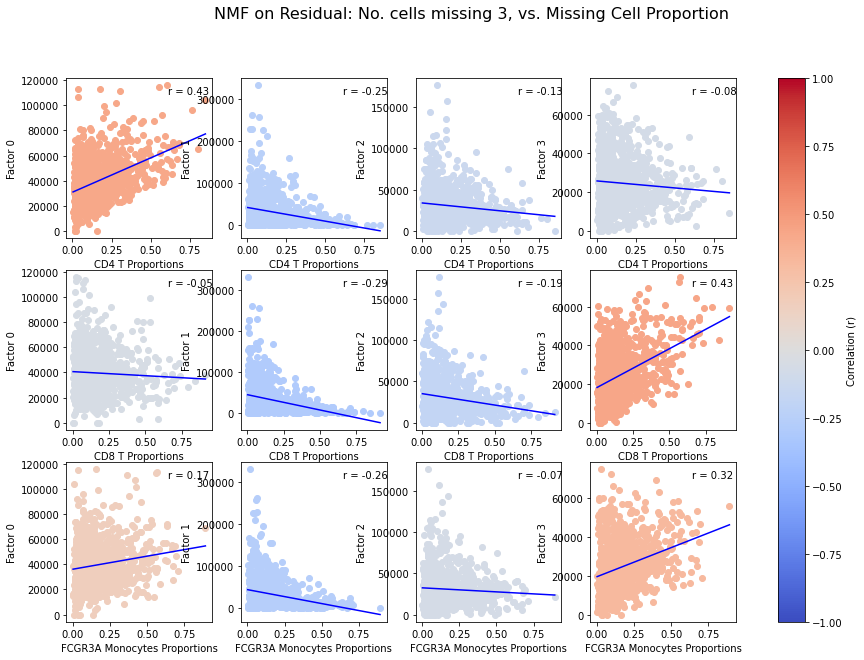

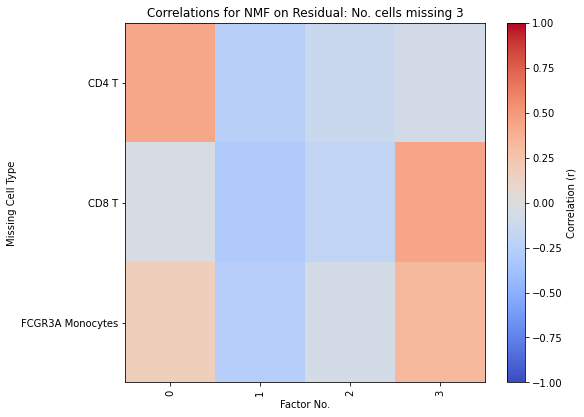

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


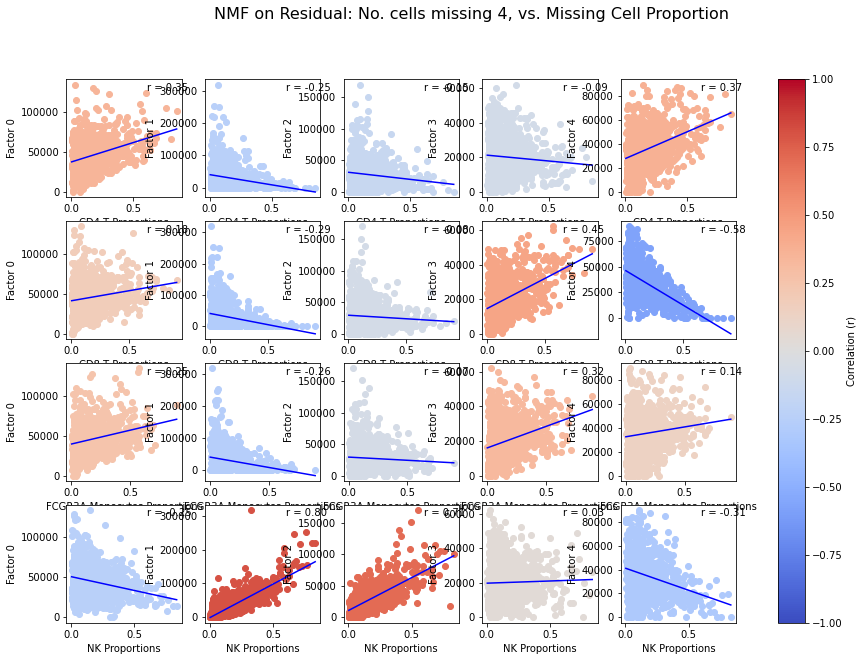

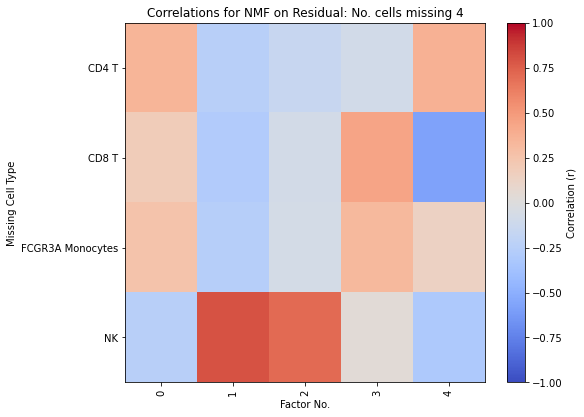

In [37]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter=5000)
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_heatmaps(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

Residual_scaled

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


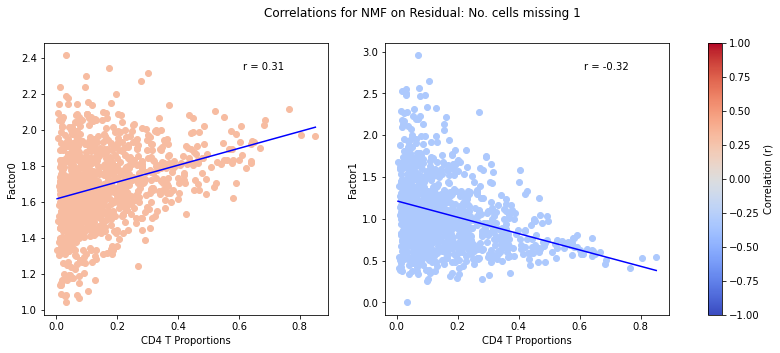

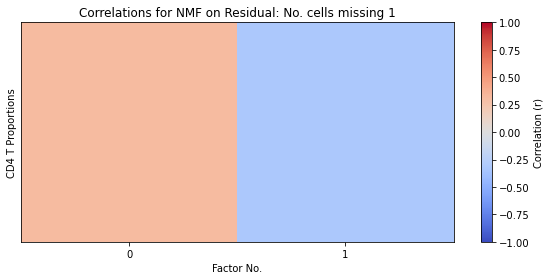

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


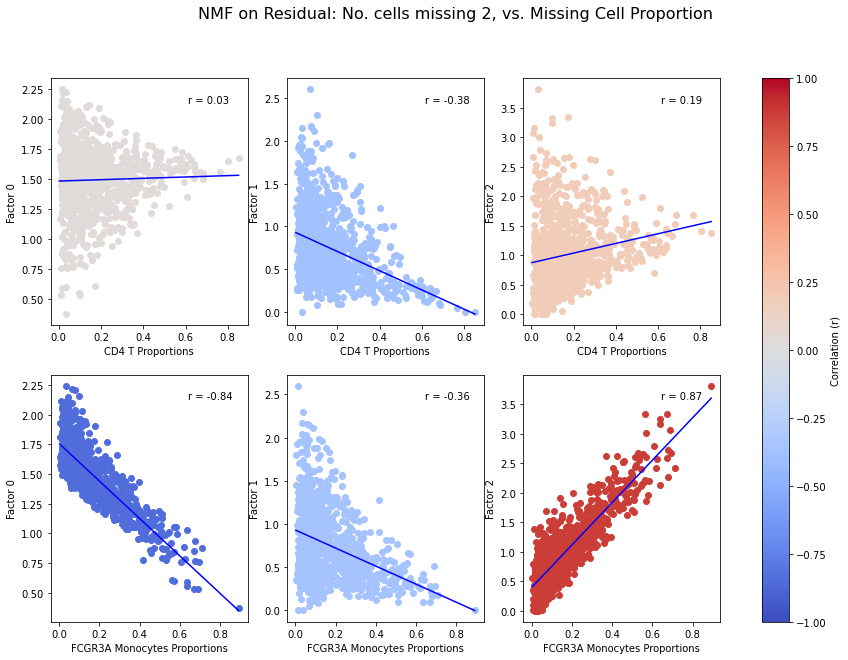

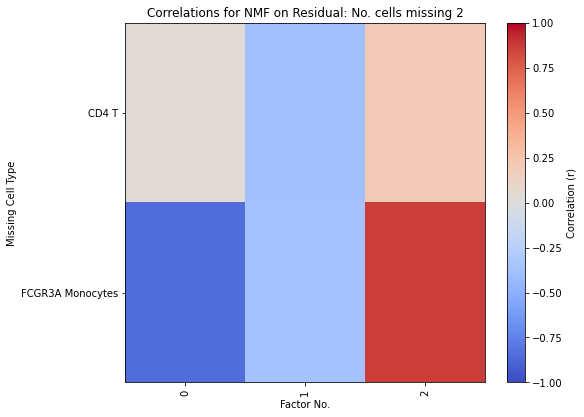

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


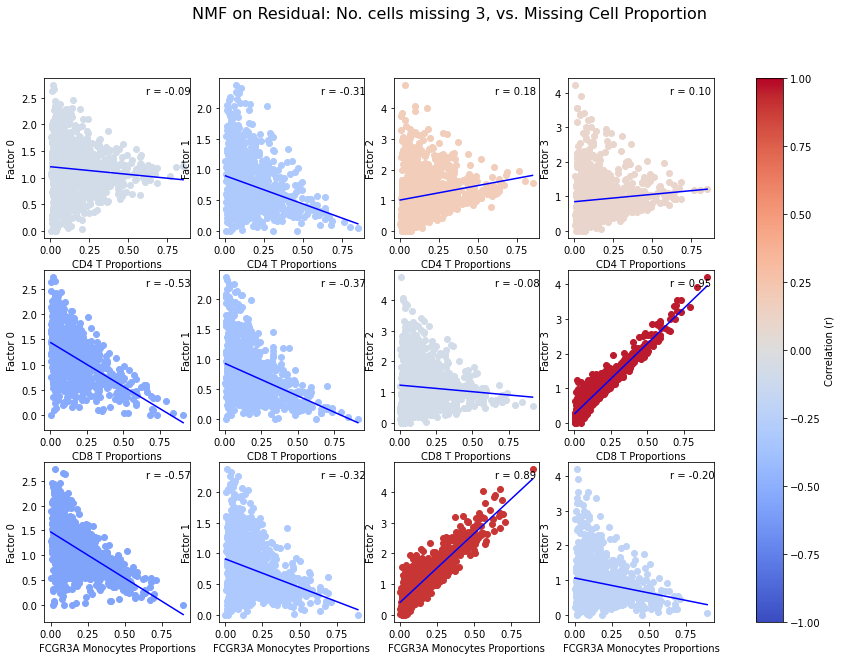

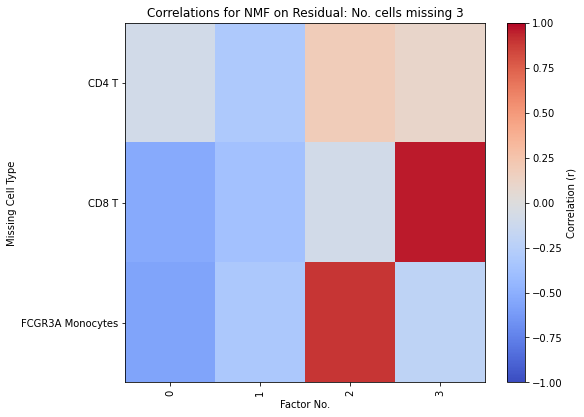

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


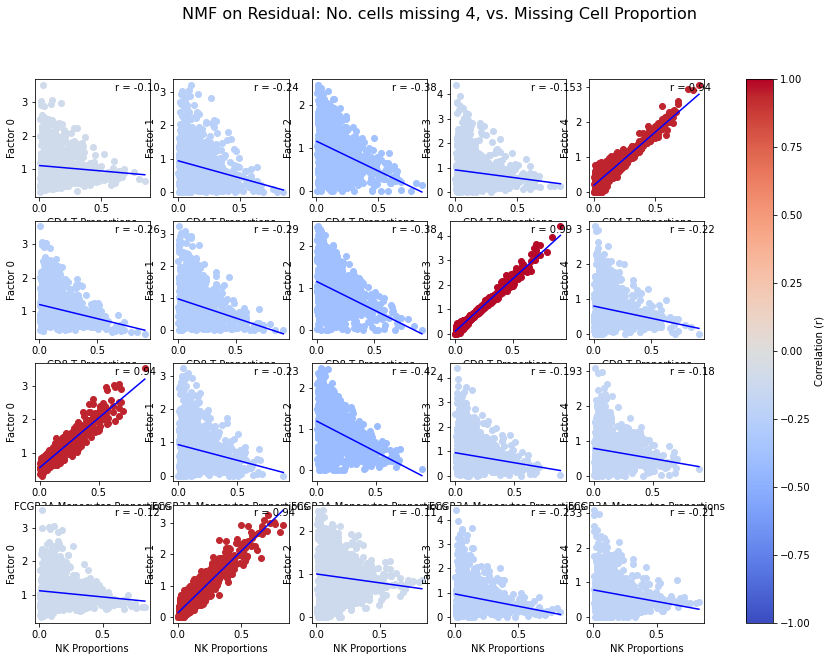

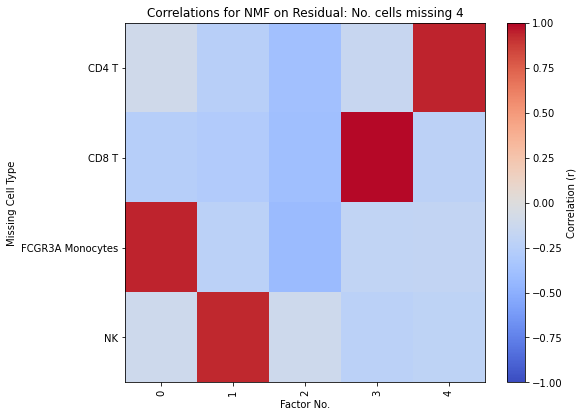

In [38]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num + 1
    nmf = NMF(n_components = num_nmf, max_iter=5000)
    res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_heatmaps(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 